### A General Algorithm for Full-Lung CT Flip Detection using Quadrant Pixel Summation 
Data Preparation  
1. For each subject, we have three lung masks, one for each view (axial, coronal and saggital). 
2. Manually generate Left-Right (LR), Top-Bottom (TB) and Front-Back (FB) flips and store Niftys in specified subdirectories.

Method 
1. Randomly sample 250 subjects from MESA Ex5, conduct manual flip generation per step (2) in data preparation. 
2. Extract the lung mask per subject, divide each mask into four quadrants and sum up the pixels in each quadrant, thereby creating a 3x2x2 tensor for each subject. 
3. Train a support vector classifier on 4 classes x 250 scan per class = 1000 scans; save the classifier and call for future function. 

#### Data Preparation 

In [1]:
# Import packages
import nibabel as nib
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd 
from nilearn import plotting
from myutils import PLF # This is a plotting function written by Soroush for better visualization. 
import seaborn as sns 
import random 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm
from utils import ParallelMe

From the cleanup directory, randomly sample 250 subjects for which we have cleaned, correctly oriented scans and masks. 

In [2]:
# From the cleanup file directory, obtain a list of subjects. 
SubDir = "/DATA/cleanup_data/data_MESA/MESA_Ex5/MESA_Ex5_FL/"
Sub = []

for subdir_name in os.listdir(SubDir):
    subdir_path = os.path.join(SubDir, subdir_name)
    
    if os.path.isdir(subdir_path):
        # Split the sub-directory name using '-' as the delimiter
        parts = subdir_name.split('-')
        
        # Check if the split resulted in at least three parts
        if len(parts) >= 3:
            
            # Extract the ID from the second part
            patient_id = parts[1]
            Sub.append(patient_id)

# Sort the ID's in ascending order
Sub_sorted = sorted(Sub, key=int)

# Randomly sample 250 subjects 
rand_idx = random.sample(range(len(Sub_sorted)), 250)
sub_test = []

for i in rand_idx: 
    sub_test.append(Sub_sorted[i])

In [32]:
# Sort the IDs in ascending order
Sub_sorted = sorted(sub_test, key=int)

# Hard-coded subject ID's to prevent re-random-sampling when running again
Sub_sorted = ['3010511', '3010600', '3010678', '3010910', '3011194', '3011470', '3011585', '3011828', '3011933', '3011976', '3012220', '3012255', '3012310', '3012557', '3012735', '3012859', '3013081', '3013308', '3013537', '3013570', '3013758', '3014010', '3014150', '3014649', '3014720', '3014860', '3014908', '3015025', '3015319', '3015564', '3015572', '3016161', '3017052', '3017460', '3017613', '3017753', '3018407', '3018415', '3018423', '3018539', '3018652', '3018911', '3019160', '3019217', '3019225', '3019616', '3019934', '3021696', '3021890', '3022218', '3022820', '4010051', '4010167', '4010523', '4010566', '4010973', '4010981', '4011473', '4011570', '4011740', '4011783', '4011830', '4012399', '4012666', '4013417', '4013476', '4013484', '4013930', '4014286', '4014421', '4014480', '4015029', '4015118', '4015231', '4015282', '4015517', '4015819', '4015878', '4016165', '4016351', '4016807', '4016823', '4016874', '4017048', '4017684', '4017773', '4017803', '4018702', '4018990', '4019016', '4019571', '4021460', '4022009', '4022602', '4022645', '4022670', '5010357', '5010586', '5011019', '5011094', '5011450', '5011582', '5013356', '5013461', '5013470', '5013631', '5013968', '5014212', '5014247', '5014352', '5015219', '5015278', '5015340', '5015634', '5016096', '5016347', '5016487', '5016592', '5017033', '5017262', '5017319', '5017599', '5018056', '5018374', '5018625', '5018951', '5019524', '5019621', '5019761', '5019907', '5021006', '5021774', '6010024', '6010202', '6010261', '6010687', '6011004', '6011020', '6011780', '6013104', '6013554', '6013651', '6013953', '6014364', '6014836', '6015239', '6015859', '6016529', '6016723', '6016898', '6017630', '6017819', '6018041', '6019480', '6021212', '6021387', '6022081', '6022413', '6022740', '7010818', '7010990', '7011121', '7011610', '7011768', '7011814', '7011849', '7011903', '7012101', '7012225', '7012330', '7012446', '7012470', '7012675', '7012950', '7013108', '7013116', '7013396', '7013574', '7013655', '7013779', '7013981', '7014074', '7014481', '7014864', '7014880', '7015089', '7015313', '7015445', '7015836', '7015887', '7016220', '7016271', '7016743', '7017073', '7017251', '7017545', '7017596', '7017898', '7018223', '7018371', '7018428', '7018800', '7019130', '7019289', '7019319', '7019394', '7019785', '7019920', '7041632', '7041969', '7042230', '7043554', '7044372', '7044852', '7044976', '8010544', '8010609', '8011206', '8011907', '8011958', '8012369', '8012466', '8013160', '8013470', '8013691', '8013705', '8013756', '8014051', '8014205', '8014302', '8014337', '8014868', '8015309', '8015635', '8015970', '8016313', '8016640', '8017530', '8018790', '8021333', '8021791', '8022003', '8022046', '8022070', '8022801', '8023247', '8023506', '8024537', '8024650', '8024782']

#### MESA Exam 5 Full-Lung Utility Functions 
These utility functions are used for MESA Exam 5 full-lung scans' flip detection. Note that the directory structure may be different for different exams. 

In [33]:
# Function for reading the lung mask niftys
def get_lung(SubDir, ID): 
    """Function takes directory path and subject ID, returns lung mask"""
    ID_dir = os.path.join(SubDir, f"MESA-{ID}-E5")
    lung = nib.load(os.path.join(ID_dir, f"MESA_Ex5_FL_{ID}_LUNG.nii.gz")).get_fdata().astype('uint8')
    return lung 

In [34]:
# Function for selecting optimal x/y/z axis slice
def max_slice_indices(lung):
    """Function takes lung mask and returns the slice indices of the largest area slice for x, y and z axis, respectively"""
    slice_areas_z = np.sum(lung, axis=(0, 1))
    largest_area_z_index = np.argmax(slice_areas_z)
    
    slice_areas_x = np.sum(lung, axis=(1, 2))
    largest_area_x_index = np.argmax(slice_areas_x)
    
    slice_areas_y = np.sum(lung, axis=(0, 2))
    largest_area_y_index = np.argmax(slice_areas_y)
    
    return largest_area_x_index, largest_area_y_index, largest_area_z_index

In [35]:
# Function for creating the 2x2 pixel sum 
def pix_sum(lung, xlc, ylc, zlc):
    """Function takes lung mask and x, y and z slice indices, returns a 3x2x2 tensor of the quadrant pixel sums for the three views"""
    pix = np.zeros((3,2,2))
    xx,yy,zz = lung.shape
    
    # axial plane - slicing on z axis 
    for i in range(2):
        for j in range(2):
            pix[0,i,1-j] = lung[i*xx//2:(i+1)*xx//2, j*yy//2:(j+1)*yy//2, zlc].mean()
            
    # coronal plane - slicing on y axis          
    for i in range(2):
        for j in range(2):
            pix[1,1-i,j] = lung[i*xx//2:(i+1)*xx//2, ylc, j*zz//2:(j+1)*zz//2].mean()
            
    # saggital plane - slicing on x axis         
    for i in range(2):
        for j in range(2):
            pix[2,i,j] = lung[xlc, i*yy//2:(i+1)*yy//2, j*zz//2:(j+1)*zz//2].mean()
            
    return pix

In [36]:
# Function for plotting the pixel sums 
def pix_plt(pix):
    """Function that takes the 3x2x2 tensor and returns three plots of the 2x2 quandrant sums"""
    # Create a single figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

    # Iterate through the first dimension of the matrix
    for i in range(3):

        # Plot the current 2x2 submatrix in the corresponding subplot
        im = axs[i].imshow(pix[i], cmap='viridis')
        axs[i].set_title(f"Matrix for axis={i} view")

        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)

    # Adjust spacing between subplots
    plt.tight_layout()

In [113]:
# Functions for manually flipping and saving scans 
output_dir_TB = '/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_TB'
output_dir_LR = '/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_LR'
output_dir_FB = '/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_FB'

# Create a top/bottom lung flipping function 
def invert_lung_TB(SubDir, ID, output_dir_TB):
    # Load the lung mask for the given ID
    lung = get_lung(SubDir, ID)
    
    # Vertically invert the lung mask
    inverted_lung_mask = np.flip(lung, axis=2)

    # Save the inverted lung mask as a NIfTI file
    output_filename = os.path.join(output_dir_TB, f"MESA_Ex5_TB_{ID}_LUNG.nii.gz")
    inverted_nifti = nib.Nifti1Image(inverted_lung_mask.astype('uint8'), affine=np.eye(4))
    inverted_nifti.header.set_data_dtype('uint8')
    nib.save(inverted_nifti, output_filename)
    
# Create a top/bottom lung flipping function 
def invert_lung_LR(SubDir, ID, output_dir_LR):
    # Load the lung mask for the given ID
    lung = get_lung(SubDir, ID)
    
    # Vertically invert the lung mask
    inverted_lung_mask = np.flip(lung, axis=0)

    # Save the inverted lung mask as a NIfTI file
    output_filename = os.path.join(output_dir_LR, f"MESA_Ex5_LR_{ID}_LUNG.nii.gz")
    inverted_nifti = nib.Nifti1Image(inverted_lung_mask.astype('uint8'), affine=np.eye(4))
    inverted_nifti.header.set_data_dtype('uint8')
    nib.save(inverted_nifti, output_filename)

# Create a front/back lung flipping function 
def invert_lung_FB(SubDir, ID, output_dir_FB):
    # Load the lung mask for the given ID
    lung = get_lung(SubDir, ID)

    # Horizontally invert the lung mask
    inverted_lung_mask = np.flip(lung, axis=1)

    # Save the inverted lung mask as a NIfTI file
    output_filename = os.path.join(output_dir_FB, f"MESA_Ex5_FB_{ID}_LUNG.nii.gz")
    inverted_nifti = nib.Nifti1Image(inverted_lung_mask.astype('uint8'), affine=np.eye(4))
    inverted_nifti.header.set_data_dtype('uint8')
    nib.save(inverted_nifti, output_filename)

#### Flipped Data Generation

In [114]:
def convert(sub):
    invert_lung_TB(SubDir, sub, output_dir_TB)
    invert_lung_LR(SubDir, sub, output_dir_LR)
    invert_lung_FB(SubDir, sub, output_dir_FB)

ParallelMe(convert, Sub_sorted, n_cores=15).run()

  0%|          | 0/250 [00:00<?, ?it/s]

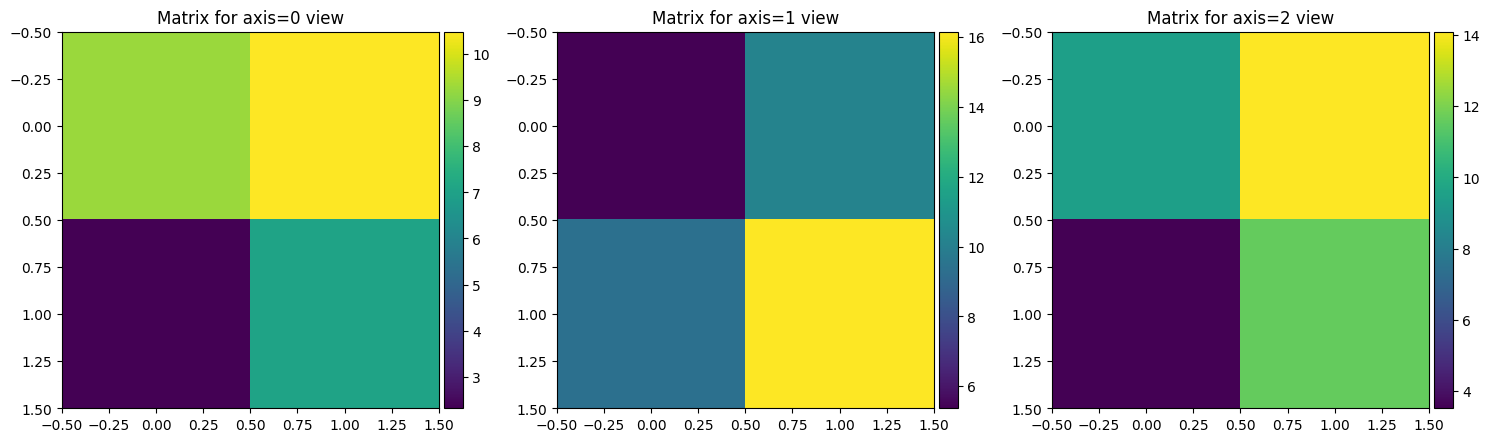

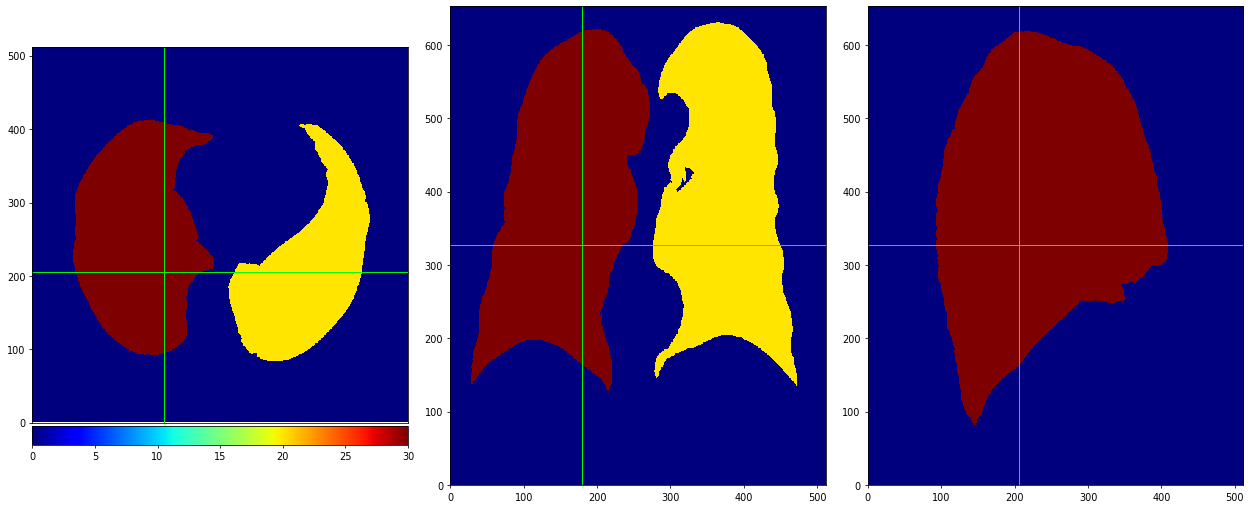

In [43]:
for sub in Sub_sorted[:1]:
    Dir = '/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_LR'
    lung = nib.load(os.path.join(Dir, f"MESA_Ex5_LR_{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    pix_plt(pix)
    PLF.plot(lung, cmaps="jet", x=xlc, y=ylc, z=zlc)

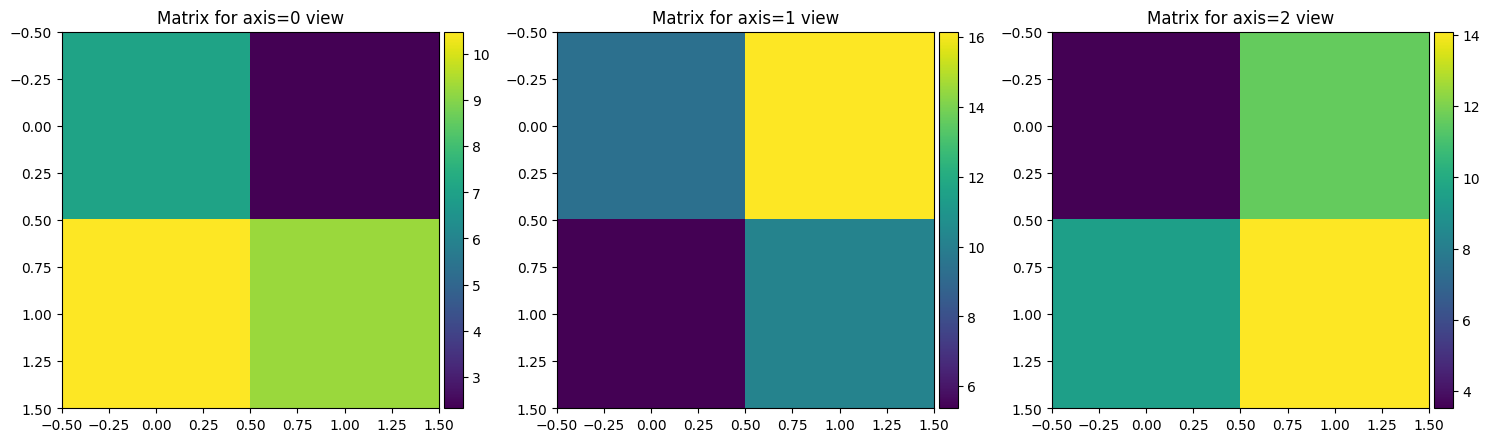

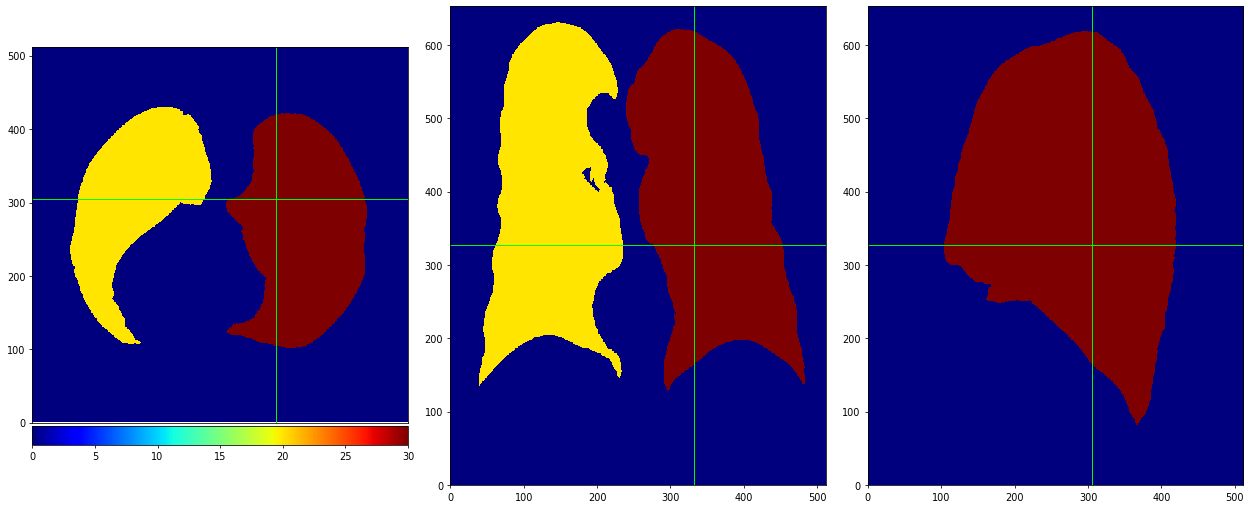

In [44]:
for sub in Sub_sorted[:1]:
    Dir = '/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_FB'
    lung = nib.load(os.path.join(Dir, f"MESA_Ex5_FB_{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    pix_plt(pix)
    PLF.plot(lung, cmaps="jet", x=xlc, y=ylc, z=zlc)

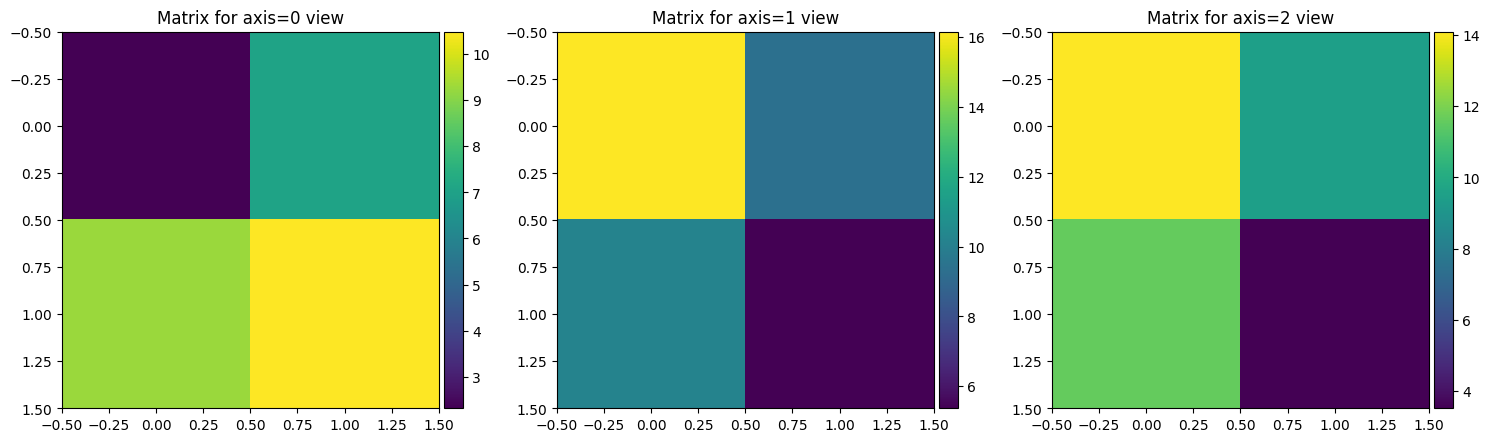

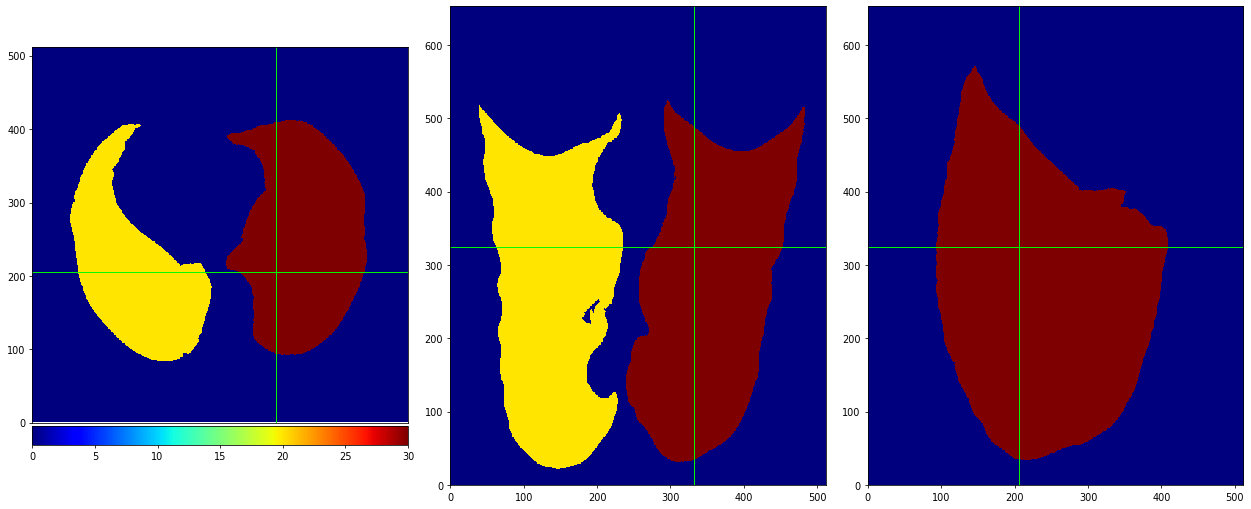

In [45]:
for sub in Sub_sorted[:1]:
    Dir = '/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_TB'
    lung = nib.load(os.path.join(Dir, f"MESA_Ex5_TB_{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    pix_plt(pix)
    PLF.plot(lung, cmaps="jet", x=xlc, y=ylc, z=zlc)

As observed, x/y/z axis flips show distinct matrices, however, individual variations could fluctuate max/min positions. To combat this problem, use a support vector classifier. 

In [116]:
lung1 = PLF.load_image('/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_FB/MESA_Ex5_FB_3010007_LUNG.nii.gz')
lung2 = PLF.load_image('/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_FB/MESA_Ex5_FB_3010058_LUNG.nii.gz')

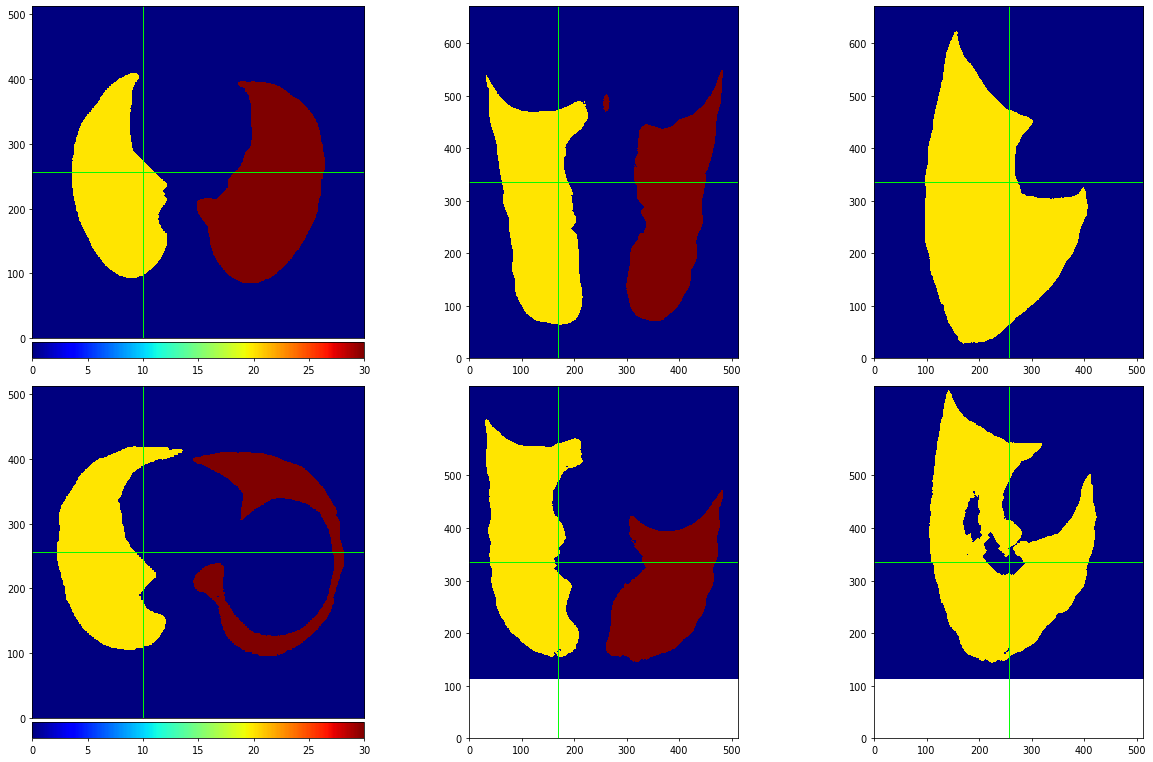

In [117]:
PLF.plot([lung1, lung2])

#### Classifier 

In [118]:
# Get trainning and testing dat

def extract_feature(sub):
    X = list()
    y = list()
    lung = get_lung(SubDir, sub)
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    X.append(pix.flatten())
    y.append(0)


    Dir = '/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_LR'  
    lung = nib.load(os.path.join(Dir, f"MESA_Ex5_LR_{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    X.append(pix.flatten())
    y.append(1)


    Dir = '/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_TB'
    lung = nib.load(os.path.join(Dir, f"MESA_Ex5_TB_{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    X.append(pix.flatten())
    y.append(2)


    Dir = '/DATA/summer_students/process_AZ/Flipped_MESA_Ex5_FB'
    lung = nib.load(os.path.join(Dir, f"MESA_Ex5_FB_{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)     
    pix = pix_sum(lung, xlc, ylc, zlc)
    X.append(pix.flatten())
    y.append(3)

    np.save(f'./Featurs/{sub}.npy', np.hstack((np.array(X), np.array(y)[:,np.newaxis])))

ParallelMe(extract_feature, Sub_sorted, n_cores=15).run()

  0%|          | 0/250 [00:00<?, ?it/s]

In [119]:
X = list()
y = list()
for sub in tqdm(Sub_sorted):
    data = np.load(f'./Featurs/{sub}.npy')
    X.extend(list(data[:, :12]))
    y.extend(list(data[:, -1]))
X = np.array(X)
y = np.array(y)
X.shape, y.shape

  0%|          | 0/250 [00:00<?, ?it/s]

((1000, 12), (1000,))

In [120]:
counts = list()
for i in tqdm(range(len(X))):
    row = X[i]
    counts.append(0)
    for j in range(i+1, len(X)):
        if np.all(row == X[j]):
            counts[-1] += 1
counts = np.array(counts)

  0%|          | 0/1000 [00:00<?, ?it/s]

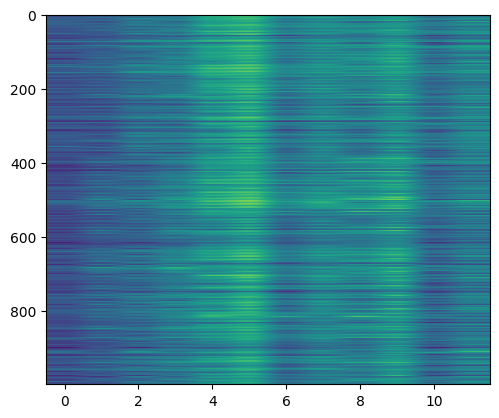

In [121]:
plt.imshow(X, aspect=0.01)

In [122]:
np.unique(X, axis=0).shape

(1000, 12)

In [126]:
classifier = SVC(kernel='linear', C=1.0, random_state=42)
scores = cross_val_score(classifier, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.97 accuracy with a standard deviation of 0.01


In [125]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the classifier
# classifier = LogisticRegression(max_iter=1000)  # Increase max_iter for convergence
classifier = SVC(kernel='linear', C=1.0, random_state=42)

# classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
# classifier = KNeighborsClassifier(n_neighbors=5) # try not to use this as comp time too long 

# Train the classifier
classifier.fit(X_train, y_train)
# Make predictions on the testing set
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9566666666666667


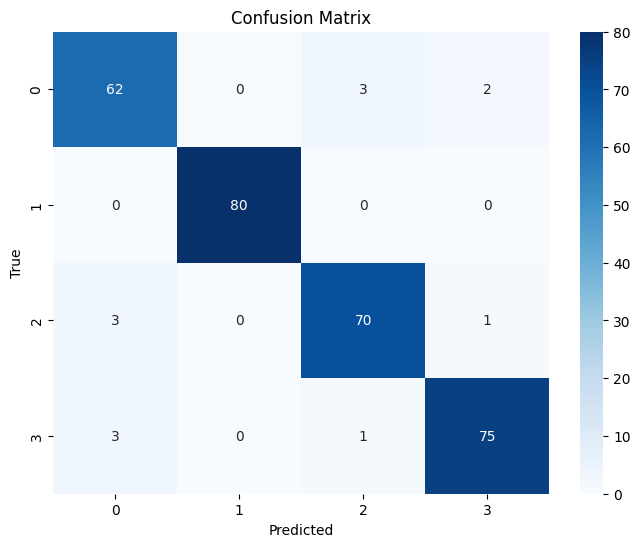

In [127]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [128]:
import joblib

joblib.dump(classifier, 'lung_flip_classifier.pkl')

['lung_flip_classifier.pkl']